In [1]:
# Importing required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

import warnings

sns.set()
warnings.filterwarnings("ignore")

In [2]:
# Importing data and date lookup

import pandas as pd
import numpy as np
import json
with open(r'acn.json', 'r') as jf:
    ev = json.load(jf)
       
# Flatten data
df = pd.json_normalize(ev, record_path =['_items'])
df.head()

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,5bc90cb9f9af8b0d7fe77cd2,0039,"Wed, 25 Apr 2018 11:08:04 GMT","Wed, 25 Apr 2018 13:20:10 GMT","Wed, 25 Apr 2018 13:21:10 GMT",7.932,2_39_78_362_2018-04-25 11:08:04.400812,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None
1,5bc90cb9f9af8b0d7fe77cd3,0039,"Wed, 25 Apr 2018 13:45:10 GMT","Thu, 26 Apr 2018 00:56:16 GMT","Wed, 25 Apr 2018 16:44:15 GMT",10.013,2_39_95_27_2018-04-25 13:45:09.617470,0002,CA-319,2-39-95-27,America/Los_Angeles,None,None
2,5bc90cb9f9af8b0d7fe77cd4,0039,"Wed, 25 Apr 2018 13:45:50 GMT","Wed, 25 Apr 2018 23:04:45 GMT","Wed, 25 Apr 2018 14:51:44 GMT",5.257,2_39_79_380_2018-04-25 13:45:49.962001,0002,CA-489,2-39-79-380,America/Los_Angeles,None,None
3,5bc90cb9f9af8b0d7fe77cd5,0039,"Wed, 25 Apr 2018 14:37:06 GMT","Wed, 25 Apr 2018 23:55:34 GMT","Wed, 25 Apr 2018 16:05:22 GMT",5.177,2_39_79_379_2018-04-25 14:37:06.460772,0002,CA-327,2-39-79-379,America/Los_Angeles,None,None
4,5bc90cb9f9af8b0d7fe77cd6,0039,"Wed, 25 Apr 2018 14:40:34 GMT","Wed, 25 Apr 2018 23:03:12 GMT","Wed, 25 Apr 2018 17:40:30 GMT",10.119,2_39_79_381_2018-04-25 14:40:33.638896,0002,CA-490,2-39-79-381,America/Los_Angeles,None,None


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [4]:
#Initial Data Preprocessing Steps
df_pre=df
def date_conversion(col):     
    date_connection_time = pd.to_datetime(df_pre[col], format="%a, %d %b %Y %X %Z")
    date_format_connect = date_connection_time.dt.tz_localize(None)
    connect_date = date_format_connect.dt.date
    df_pre[col] = connect_date
    df_pre[col]=df_pre[col].astype('datetime64[ns]')
df_pre['doneChargingTime'].fillna(df_pre['disconnectTime'],inplace=True) # Fill Null values
date_conversion('connectionTime')
date_conversion('disconnectTime')
date_conversion('doneChargingTime')
def ev_univ(input_col,pred_col):
    ev_univ = df_pre[[input_col,pred_col]]
    ev_univ_agg = ev_univ.groupby([input_col]).agg({pred_col:np.sum})
    return ev_univ_agg
uni_done = ev_univ('doneChargingTime','kWhDelivered')
uni_conn = ev_univ('connectionTime','kWhDelivered')
uni_disconn = ev_univ('disconnectTime','kWhDelivered')
uni_2=uni_disconn.reset_index()
df_1=uni_2
df_1

,disconnectTime,kWhDelivered
0,2018-04-25,151.103
1,2018-04-26,385.389
2,2018-04-27,409.963
3,2018-04-28,540.545
4,2018-04-29,267.643
...,...,...
1074,2021-09-10,393.768
1075,2021-09-11,315.598
1076,2021-09-12,179.279
1077,2021-09-13,368.374


In [5]:
#Importing Date Lookup table
      
# Flatten data
date_df = pd.read_csv(r'date_lookup.csv')
date_df.head()

,Date,Year,Month,Day
0,25-Apr-2018,2018,4,25
1,26-Apr-2018,2018,4,26
2,27-Apr-2018,2018,4,27
3,28-Apr-2018,2018,4,28
4,29-Apr-2018,2018,4,29


In [6]:
#Lookup Table processing
date_df['Date'] = date_df['Date'].astype('datetime64')
date_df.set_index('Date')
merge=pd.merge(date_df,df_1, how='left',left_on='Date',right_on='disconnectTime')
merge['day_of_week'] = merge['Date'].dt.weekday
merge["IsWeekend"] = merge["day_of_week"] >= 5
analy = merge[['Date','kWhDelivered']]
analy_weekend = merge[['Date','IsWeekend','kWhDelivered']]
analy_1=analy.set_index('Date')
analy_weekend_1=analy_weekend.set_index('Date')
#KNN Imputation
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df = pd.DataFrame(imputer.fit_transform(analy_weekend_1),columns = analy_weekend_1.columns)
#Concatenating date lookup and source data
x1=pd.concat([analy_weekend,df], axis=1, ignore_index=True)
final=x1
final.drop(3,axis=1,inplace=True)
final.drop(2,axis=1,inplace=True)
final_df=final.rename(columns={0:'Date',1: "IsWeekend", 4: "kWhDelivered"})
uni_3=final_df
# uni_3=uni_3.set_index('Date')
uni_3.index.freq = 'D'
uni_3_filter=uni_3['kWhDelivered']
uni_3.rename(columns={'kWhDelivered':'Kwh'},inplace=True)
uni_3_filter = uni_3
uni_3_filter = uni_3_filter.drop('IsWeekend',axis=1,inplace=True)
data=uni_3 # Data for forecastinng

In [7]:
data

,Date,Kwh
0,2018-04-25,151.103
1,2018-04-26,385.389
2,2018-04-27,409.963
3,2018-04-28,540.545
4,2018-04-29,267.643
...,...,...
1234,2021-09-10,393.768
1235,2021-09-11,315.598
1236,2021-09-12,179.279
1237,2021-09-13,368.374


In [8]:
data['Kwh_1']=data['Kwh'].shift(+1)
data['Kwh_7']=data['Kwh'].shift(+7)
data['Kwh_14']=data['Kwh'].shift(+14)
data

,Date,Kwh,Kwh_1,Kwh_7,Kwh_14
0,2018-04-25,151.103,NaN,NaN,NaN
1,2018-04-26,385.389,151.103,NaN,NaN
2,2018-04-27,409.963,385.389,NaN,NaN
3,2018-04-28,540.545,409.963,NaN,NaN
4,2018-04-29,267.643,540.545,NaN,NaN
...,...,...,...,...,...
1234,2021-09-10,393.768,324.797,163.255,239.352
1235,2021-09-11,315.598,393.768,241.266,347.135
1236,2021-09-12,179.279,315.598,236.295,218.280
1237,2021-09-13,368.374,179.279,142.181,246.940


In [9]:
data=data.dropna()
data

,Date,Kwh,Kwh_1,Kwh_7,Kwh_14
14,2018-05-09,506.984000,623.567405,414.264000,151.103
15,2018-05-10,514.385299,506.984000,538.226000,385.389
16,2018-05-11,531.441348,514.385299,593.196722,409.963
17,2018-05-12,487.330144,531.441348,552.874297,540.545
18,2018-05-13,449.318366,487.330144,312.118000,267.643
...,...,...,...,...,...
1234,2021-09-10,393.768000,324.797000,163.255000,239.352
1235,2021-09-11,315.598000,393.768000,241.266000,347.135
1236,2021-09-12,179.279000,315.598000,236.295000,218.280
1237,2021-09-13,368.374000,179.279000,142.181000,246.940


In [10]:
import numpy as np
x1,x2,x3,y=data['Kwh_1'],data['Kwh_7'],data['Kwh_14'],data['Kwh'] # pandas dataframce
x1,x2,x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y) # array
x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3),axis=1)
print(final_x)

[[623.56740514 414.264      151.103     ]
 [506.984      538.226      385.389     ]
 [514.38529898 593.19672192 409.963     ]
 ...
 [315.598      236.295      218.28      ]
 [179.279      142.181      246.94      ]
 [368.374      169.417      410.133     ]]


In [11]:
prop_train = 0.7
n_train = round(prop_train * 1225)
X_train,X_test,y_train,y_test=final_x[:n_train],final_x[n_train:],y[:n_train],y[n_train:]

In [12]:
X_train,X_test,y_train,y_test=final_x[:n_train],final_x[n_train:],y[:n_train],y[n_train:]

In [13]:
import sklearn.gaussian_process as gp

In [14]:
# X_tr <-- training observations [# points, # features]
# y_tr <-- training labels [# points]
# X_te <-- test observations [# points, # features]
# y_te <-- test labels [# points]

In [15]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

In [16]:
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

In [17]:
model.fit(X_train, y_train)
params = model.kernel_.get_params()

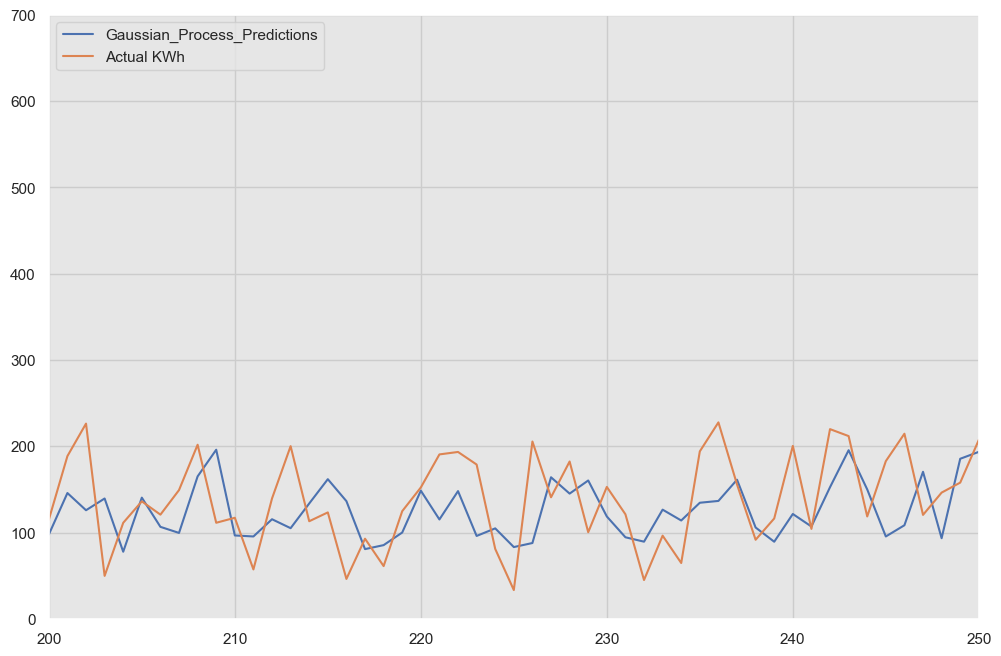

In [18]:
y_pred, std = model.predict(X_test, return_std=True)

# pred=model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(y_pred,label='Gaussian_Process_Predictions')
plt.plot(y_test,label='Actual KWh')
plt.legend(loc="upper left")
plt.axis([200,250,0,700])
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_gp=sqrt(mean_squared_error(y_pred,y_test))

In [22]:
print('Mean Squared Error for Gaussian Process Model is:',rmse_gp)

Mean Squared Error for Gaussian Process Model is: 57.92037149547372


In [28]:
from sklearn.metrics import r2_score
r2_gp_uni = r2_score(y_test,y_pred)
print('R2 Score for Gaussian Process Model is:',r2_gp_uni)

In [29]:
print('R2 Score for Gaussian Process Model is:',r2_gp_uni)

R2 Score for Gaussian Process Model is: 0.47316605788458954


Any R2 value less than 1.0 indicates that at least some variability in the data cannot be accounted for by the model (e.g., an R2 of 0.5 indicates that 50% of the variability in the outcome data cannot be explained by the model).

In [30]:
from sklearn.metrics import mean_absolute_percentage_error
mape_gp_multi =mean_absolute_percentage_error(y_test,y_pred)
print('MAPE Score for Gaussian Process Model is:',mape_gp_multi)

MAPE Score for Gaussian Process Model is: 0.5690968973181632
